# Analyse de la Fr√©quence des Donn√©es GPS
Ce notebook analyse les intervalles temporels entre les points GPS pour d√©tecter des fr√©quences, des anomalies, classifier les types de d√©placements et g√©n√©rer des visualisations utiles

## Importation des librairies

In [9]:
import geopandas as gpd 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import os

## Chargement des donn√©es

In [10]:
current_dir = os.getcwd()  #chemin vers le r√©pertoire contenant le script
data_folder = os.path.abspath(os.path.join(current_dir, "..", "participant-data-semain43"))  #chemin vers le repertoire contenant le script
data_path = os.path.join(data_folder, "Cleaned_Trajectories.gpkg")  #eonstruction du chemin absolu vers le dossier contenant les donn√©es

print("Chargement des trajectoires...")
df = gpd.read_file(data_path, layer='trajectories')  #lecture du fichier GeoPackage avec GeoPandas, couche 'trajectories'
print("Colonnes disponibles :", df.columns)

Chargement des trajectoires...
Colonnes disponibles : Index(['timestamp', 'participant_virtual_id', 'lat', 'lon', 'trajectory_id',
       'speed', 'geometry'],
      dtype='object')


## Pr√©traitement des donn√©es

In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)  #conversion de la colonne 'timestamp' au format datetime
df = df.sort_values(by=['trajectory_id', 'timestamp'])  #tri des points GPS par identifiant de trajectoire et par temps

## Analyse de la fr√©quence temporelle

In [12]:
df['time_diff_min'] = df.groupby('trajectory_id')['timestamp'].diff().dt.total_seconds() / 60  #calcul de temps entre deux points successifs d'un meme trajectoire
df['time_diff_min'].describe()  #affichage des statistiques descriptives sur les frequences

count    129803.000000
mean          0.057103
std           0.104794
min           0.016667
25%           0.033333
50%           0.033333
75%           0.033333
max           6.016667
Name: time_diff_min, dtype: float64

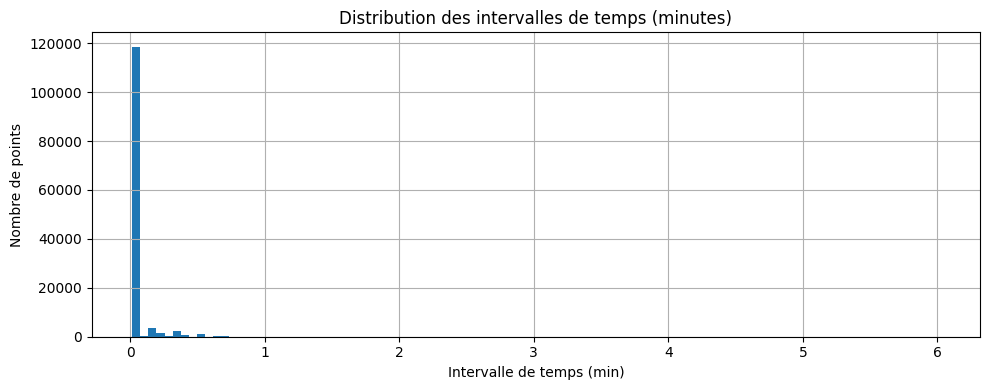

In [13]:
plt.figure(figsize=(10, 4))
df['time_diff_min'].dropna().hist(bins=100)
plt.title("Distribution des intervalles de temps (minutes)")
plt.xlabel("Intervalle de temps (min)")
plt.ylabel("Nombre de points")
plt.grid(True)
plt.tight_layout()
plt.show()

## V√©rification des valeurs manquantes

In [14]:
{
    "missing_timestamps": df['timestamp'].isna().sum(),
    "missing_geometry": df['geometry'].isna().sum(),
    "missing_speed": df['speed'].isna().sum()
}

{'missing_timestamps': np.int64(0),
 'missing_geometry': np.int64(0),
 'missing_speed': np.int64(0)}

## D√©tection d'anomalies temporelles

In [15]:
anomalies = df[df['time_diff_min'] > 10]  #extraction des intervalles de temps superieurs a 10 min
print(f"Nombre d'intervalles > 10 minutes : {len(anomalies)}") 

Nombre d'intervalles > 10 minutes : 0


## Fr√©quence moyenne par participant

In [16]:
participant_freq = df.groupby('participant_virtual_id')['time_diff_min'].mean().sort_values()  #tri des points GPS par identifiant et temps
participant_freq.head()

participant_virtual_id
9999961    0.057103
Name: time_diff_min, dtype: float64

## Analyse journali√®re et horaire

In [17]:
df['hour'] = df['timestamp'].dt.hour  #extraction de l'heure pour chaque point GPS
df['weekday'] = df['timestamp'].dt.day_name()  # extraction du jour de la semaine
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_freq = df.groupby('hour')['time_diff_min'].mean()  #calcul de temps entre deux points successifs d'une m√™me trajectoire
weekday_freq = df.groupby('weekday')['time_diff_min'].mean().reindex(weekday_order) 

## Visualisation de hourly_freq

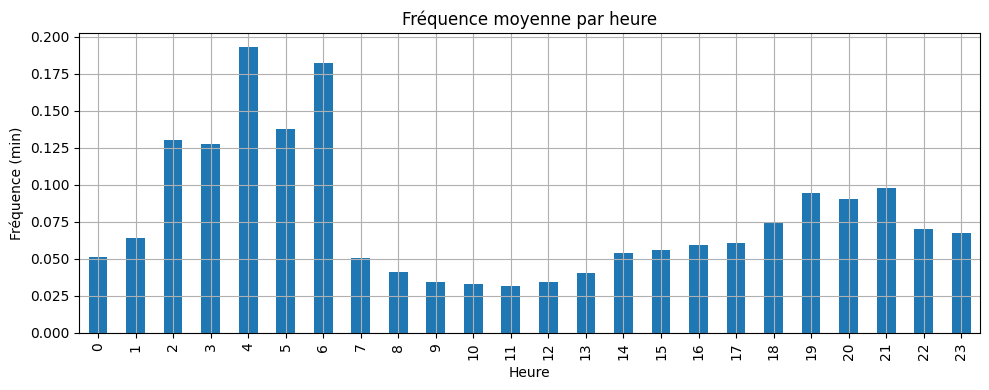

In [18]:
plt.figure(figsize=(10, 4))
hourly_freq.plot(kind='bar')
plt.title("Fr√©quence moyenne par heure")
plt.xlabel("Heure")
plt.ylabel("Fr√©quence (min)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualisation de weekday_freq

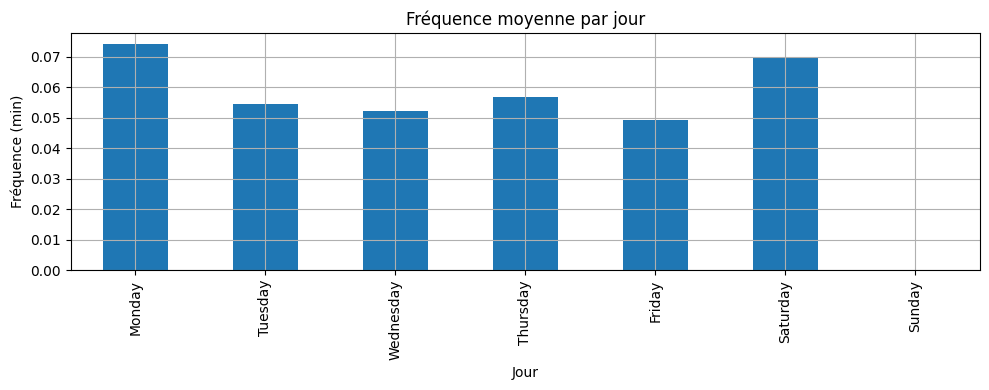

In [19]:
plt.figure(figsize=(10, 4))
weekday_freq.plot(kind='bar') 
plt.title("Fr√©quence moyenne par jour")
plt.xlabel("Jour")
plt.ylabel("Fr√©quence (min)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Estimation de la vitesse

In [ ]:
#pour chaque point d'un trajectoire on recupere la position du point precedent
df['prev_geom'] = df.groupby('trajectory_id')['geometry'].shift()

#calcule la distance entre chaque point et le point precedent si un point est absent on met NaN
df['dist_m'] = df.apply(
    lambda row: row['geometry'].distance(row['prev_geom']) if pd.notnull(row['prev_geom']) else None,
    axis=1
)

#calcul de la vitesse estimee entre deux points consecutifs (en m√®tres/seconde)
#la duree est en min donc on multiplie par 60 pour la convertir en sec
df['speed_est'] = df['dist_m'] / (df['time_diff_min'] * 60)

#remplacer les vitesses infinies par des valeurs manquantes (pd.NA)
df['speed_est'] = df['speed_est'].replace([float('inf'), -float('inf')], pd.NA)

df['speed_est'].describe()


count    1.298030e+05
mean     3.253102e-05
std      2.362221e-04
min      0.000000e+00
25%      0.000000e+00
50%      3.800585e-07
75%      1.715938e-05
max      6.342064e-03
Name: speed_est, dtype: float64

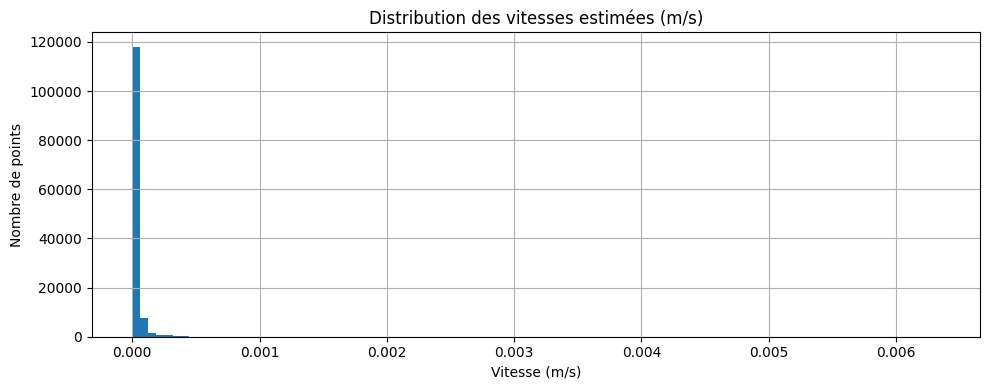

In [21]:
plt.figure(figsize=(10, 4))
df['speed_est'].dropna().clip(upper=50).hist(bins=100)
plt.title("Distribution des vitesses estim√©es (m/s)")
plt.xlabel("Vitesse (m/s)")
plt.ylabel("Nombre de points")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classification des types de d√©placement

In [22]:
#`pd.cut` est utilis√© pour creer 'movement_type' qui va contenir ('stop', 'walk', 'transport') selon la vitesse estimee

df['movement_type'] = pd.cut(df['speed_est'],                       
    bins=[-0.1, 0.1, 1.5, 50],              # Les seuils utilises pour classifier :
                                            # -0.1 √† 0.1 m/s consid√©r√© comme un arr√™t stop pour inclure 0 (cas d'arr√™t complet)
                                            # - de 0.1 √† 1.5 m/s    ‚Üí consid√©r√© comme de la marche ('walk') (‚âà 5.4 km/h ‚Üí vitesse moyenne de marche)
                                            # - de 1.5 √† 50 m/s     ‚Üí consid√©r√© comme du transport motoris√© ('transport')
    labels=['stop', 'walk', 'transport']   
)

#√ßa va nous donner par exemple combien de fois le participant etait arret√©, marchait ou se depla√ßait en transport
print("\n--- R√©partition des types de mouvements d√©tect√©s ---")
print(df['movement_type'].value_counts())



--- R√©partition des types de mouvements d√©tect√©s ---
movement_type
stop         129803
walk              0
transport         0
Name: count, dtype: int64


## Heatmap spatio-temporelle

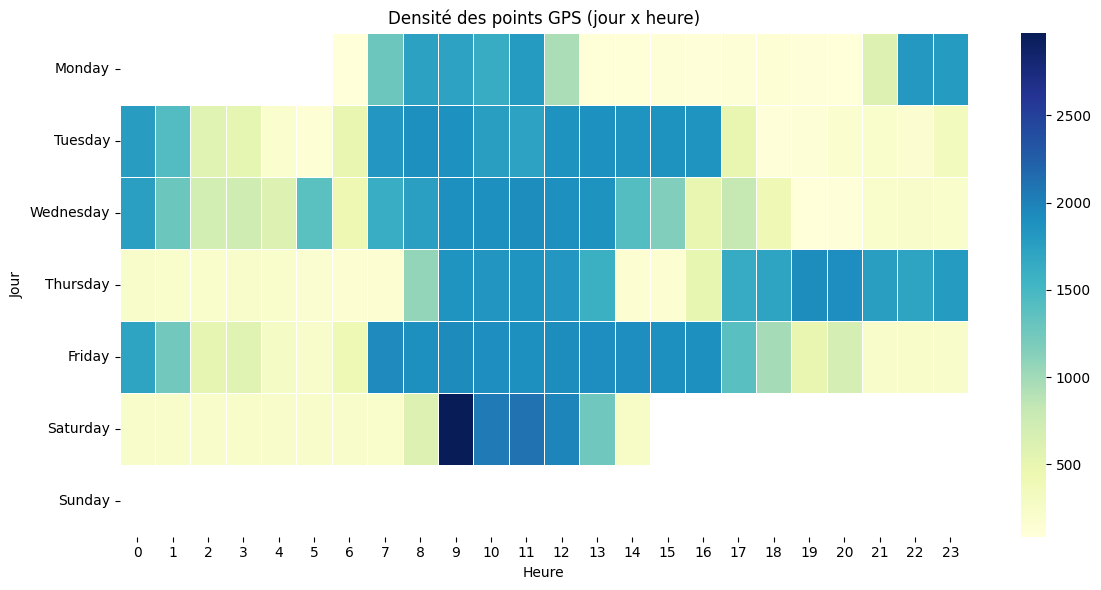

In [23]:
heatmap_data = df.groupby(['weekday', 'hour']).size().unstack().reindex(weekday_order)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title("Densit√© des points GPS (jour x heure)")
plt.xlabel("Heure")
plt.ylabel("Jour")
plt.tight_layout()
plt.show()

Cette cellule analyse les points GPS enregistr√©s le samedi √† 9h suite au pic observ√© dans la heatmap dessus.
Elle permet d‚Äôidentifier les participants actifs (pour apr√©s si on va tester avec plusieurs) √† ce moment et de visualiser leur trajectoire pour mieux comprendre ce comportement.

Participants actifs le samedi √† 9h (class√©s par nombre de points) :
participant_virtual_id
9999961    2972
Name: count, dtype: int64


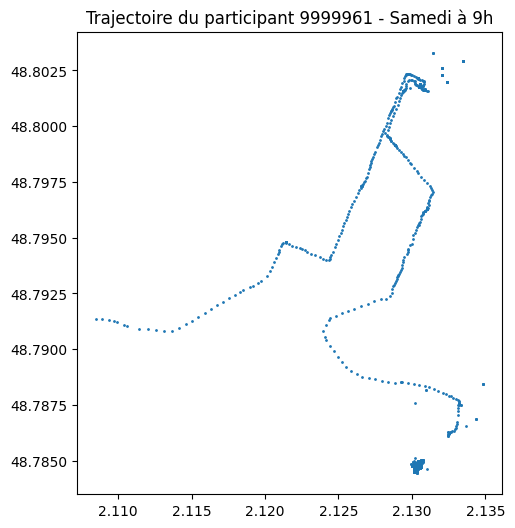

In [24]:
# Filtrer les points GPS qui ont √©t√© enregistr√©s un samedi √† 9h
points_samedi_9h = df[(df['hour'] == 9) & (df['weekday'] == 'Saturday')]

# Afficher les participants concern√©s, tri√©s par nombre de points
participant_counts = points_samedi_9h['participant_virtual_id'].value_counts()
print("Participants actifs le samedi √† 9h (class√©s par nombre de points) :")
print(participant_counts)


# Extraire les points de ce participant √† ce cr√©neau
traj_samedi_9h = df[(df['participant_virtual_id'] == 9999961) &
                    (df['hour'] == 9) &
                    (df['weekday'] == 'Saturday')]

# Afficher une carte simple avec geopandas
traj_samedi_9h.plot(markersize=1, figsize=(8, 6), legend=True)
plt.title("Trajectoire du participant 9999961 - Samedi √† 9h")
plt.show()



## Vitesse cumul√©e par participant

In [25]:
agg = df.groupby("participant_virtual_id").agg({  # Agr√©gation par participant : distance totale, dur√©e totale, vitesse moyenne
    "dist_m": "sum",
    "time_diff_min": "sum"
})
agg["avg_speed_mps"] = agg["dist_m"] / (agg["time_diff_min"] * 60)
agg["avg_speed_kmh"] = agg["avg_speed_mps"] * 3.6
agg.sort_values("avg_speed_kmh", ascending=False).head()  # Tri des points GPS par identifiant de trajectoire et par temps croissant

dist_m  time_diff_min  avg_speed_mps  avg_speed_kmh
participant_virtual_id                                                       
9999961                 12.97464         7412.1       0.000029       0.000105

In [34]:
# ==========================================
# Rapport HTML enrichi avec images
# ==========================================

# Liste des images √† int√©grer (doivent d√©j√† √™tre g√©n√©r√©es dans le notebook)
images = [
    "frequency_histogram.png",
    "hourly_freq.png",
    "weekday_freq.png",
    "speed_distribution.png",
    "heatmap_weekday_hour.png"
]

# Cr√©ation de blocs HTML <img> pour chaque image
image_blocks = ""
for img in images:
    img_path = os.path.join("..", "participant-data-semain43", img)  # Chemin relatif pour HTML
    image_blocks += f"<h3>{img.replace('_', ' ').split('.')[0].title()}</h3>"
    image_blocks += f"<img src='{img_path}' alt='{img}' width='700px' style='margin-bottom:20px;'><br>"

# R√©cup√©rer les tableaux √† afficher
speed_table = avg_speed_kmh.reset_index(name='avg_speed_kmh').to_html(index=False)
freq_table = avg_time_diff.reset_index(name='avg_time_diff_min').to_html(index=False)

# G√©n√©rer le contenu HTML
html_content = f"""
<h1>Rapport des Trajectoires GPS</h1>
<p><strong>Date de g√©n√©ration :</strong> {generation_date}</p>
<p><strong>Nombre de participants :</strong> {participant_count}</p>

<h2>üìä Vitesse moyenne par participant (km/h)</h2>
{speed_table}

<h2>üïí Fr√©quence moyenne par participant (min)</h2>
{freq_table}

<h2>üìà Visualisations</h2>
{image_blocks}

<p style='font-size: small; color: gray;'>Rapport g√©n√©r√© automatiquement √† partir des donn√©es analys√©es.</p>
"""

# Sauvegarde dans un fichier HTML
html_path = os.path.join(report_folder, "rapport_gps_complet.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html_content)

print(f"‚úîÔ∏è Rapport HTML enrichi sauvegard√© ici : {html_path}")


‚úîÔ∏è Rapport HTML enrichi sauvegard√© ici : c:\Users\22302668\Desktop\CapsuleV2\participant-data-semain43\rapport_html\rapport_gps_complet.html
